## Global variables

In [1]:
redo_training = False

#path to pickle file
path_data = 'pickle_files/churn_all_data_2020-01-08_14-42.pickle'
path_trees_estimators = 'pickle_files/churn_trees_estimators_2020-01-06_16-01.pickle'

## Importing librairies

In [2]:
import sys
!{sys.executable} -m pip install -r requirements.txt

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

import sklearn, pickle,datetime
from sklearn import preprocessing
from sklearn.feature_selection import mutual_info_classif,f_classif

# Dataset description

In [4]:
churn = pd.read_csv('datasets/telecom_churn_dataset/churn_dataset.csv')
churn.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [5]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
state                     3333 non-null object
account length            3333 non-null int64
area code                 3333 non-null int64
phone number              3333 non-null object
international plan        3333 non-null object
voice mail plan           3333 non-null object
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64

The info() command gives information about the columns types. To avoid loosing information we want to use the maximum features available. For this purpose we need the features to be of type int or float, because models used are uncompatible with the type object.

In [6]:
churn.describe()

,account length,area code,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


The describe command summarizes the numerical features.

In [7]:
print("Percentage of values per feature:\n" )
counts = churn.count()
for col,t in zip(counts.index,counts):
    perc = (t/len(churn))*100
    print(col,': ',round(perc,2),'%')

Percentage of values per feature:

state :  100.0 %
account length :  100.0 %
area code :  100.0 %
phone number :  100.0 %
international plan :  100.0 %
voice mail plan :  100.0 %
number vmail messages :  100.0 %
total day minutes :  100.0 %
total day calls :  100.0 %
total day charge :  100.0 %
total eve minutes :  100.0 %
total eve calls :  100.0 %
total eve charge :  100.0 %
total night minutes :  100.0 %
total night calls :  100.0 %
total night charge :  100.0 %
total intl minutes :  100.0 %
total intl calls :  100.0 %
total intl charge :  100.0 %
customer service calls :  100.0 %
churn :  100.0 %


Looking for missing values, that could lead to some biais.

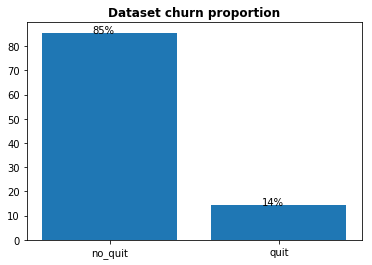

In [8]:
no_quit = churn[churn['churn']==False]

perc_no_quit = (len(no_quit)/len(churn))*100
perc_quit = ((len(churn)-len(no_quit))/len(churn)) *100

plot = plt.bar(x=['no_quit','quit'],height=[perc_no_quit,perc_quit])
plt.title('Dataset churn proportion',fontweight='bold')

for i in plot.patches:
    plt.text(x =i.get_x()+0.3,y=i.get_height(),s = "{}{}".format(int(i.get_height()),'%'))

Here we are looking at our target (churn) proportion. It is important to notice that a majority of customers are not leaving. This proportion could meen that it will be more difficult for the models to predict quitting customers. We can tell that the datset is imbalanced.

# Dataset preprocessing

In [9]:
print('state unique values',len(np.unique(churn.state.values)))

print('phone number unique values',len(np.unique(churn['phone number'].values)))
churn = churn.drop(columns=['phone number'])

state unique values 51
phone number unique values 3333


In [10]:
drop_col = []

for col in churn.columns:
    try:
        print(col,len(np.unique(churn[col].values)))
        if churn.shape[0] == len(np.unique(churn[col].values)):
            drop_col.append(col)
    except:
        print('---Error with columns: ',col)
#churn.drop(columns=drop_col,inplace=True)
print('\n \nColumns: ',drop_col,' were deleted')

state 51
account length 212
area code 3
international plan 2
voice mail plan 2
number vmail messages 46
total day minutes 1667
total day calls 119
total day charge 1667
total eve minutes 1611
total eve calls 123
total eve charge 1440
total night minutes 1591
total night calls 120
total night charge 933
total intl minutes 162
total intl calls 21
total intl charge 162
customer service calls 10
churn 2

 
Columns:  []  were deleted


The phone number feature is deleted because there is one value per individual, it will bring no information to our model

In [11]:
from sklearn.preprocessing import LabelEncoder,LabelBinarizer

le = LabelEncoder()
le = le.fit(np.unique(churn.state.values))

churn['state'] = le.transform(churn['state'])


lb = LabelBinarizer()

churn['international plan'] = lb.fit_transform(churn['international plan'])
churn['voice mail plan'] = lb.fit_transform(churn['voice mail plan'])

churn.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In order to have only features of type int or float: <br>
- the state feature has been encoded into 51 int values
- the international and voice mail plans features have been binarized

In [12]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
state                     3333 non-null int32
account length            3333 non-null int64
area code                 3333 non-null int64
international plan        3333 non-null int32
voice mail plan           3333 non-null int32
number vmail messages     3333 non-null int64
total day minutes         3333 non-null float64
total day calls           3333 non-null int64
total day charge          3333 non-null float64
total eve minutes         3333 non-null float64
total eve calls           3333 non-null int64
total eve charge          3333 non-null float64
total night minutes       3333 non-null float64
total night calls         3333 non-null int64
total night charge        3333 non-null float64
total intl minutes        3333 non-null float64
total intl calls          3333 non-null int64
total intl charge         3333 non-null float64
customer service calls    3333 non-null int64
chu

We can notice that no more features are of type object, it was the goal of the preprocessing part 

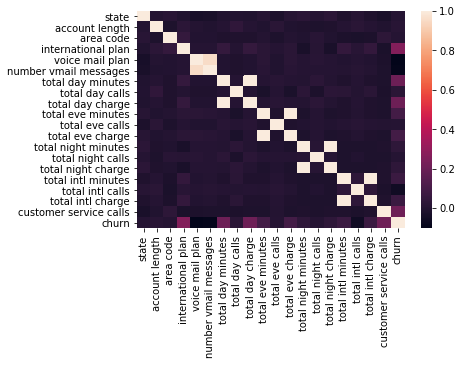

In [13]:
corr_m = churn.corr()
sns.heatmap(corr_m)

Thanks to the correlation matrix, we notice that:
- total intl minutes and total intl charge are correlated
- total night minutes and total night charge are correlated
- total eve minutes and total eve charge are correlated
- total day minutes and total day charge are correlated

This seems logical because the more minutes a customer spends on call the more he is charged. Indeed there is no correlation with the number of calls.

Even though the voice mail plan feature is correlated with number vmail messages, we must keep both of them because they do not bring same information. There are slighlty less correlated than features mentionned above. 

We can also notice the churn feature which is our target, is slightly corelated with the international plan, total day minutes (and total day charge because correlated with the precedent feature) and the customer service call. It could give us some information on the feattures that are the most involved in customers churn.

In [14]:
# Create correlation matrix
corr_matrix = churn.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.99
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
print('Deleted features are : ', to_drop)

churn.drop(columns=to_drop,inplace=True)

Deleted features are :  ['total day charge', 'total eve charge', 'total night charge', 'total intl charge']


We keep only one feature, between couples of highly correlated variables to avoid unnessecary computation.

# Training

In [15]:
X = np.array(churn.drop(columns=['churn']))
X = preprocessing.scale(X)

y = np.array(churn['churn'])

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)

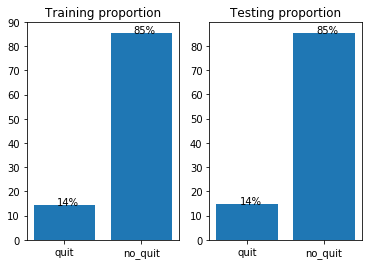

In [16]:
fig,(ax1,ax2) = plt.subplots(1,2)

#Training proportion
perc_quit = (np.count_nonzero(y_train)/len(y_train))*100
ax1.set_title('Training proportion')
ax1.bar(x=['quit','no_quit'],height=[perc_quit,100-perc_quit])

for i in ax1.patches:
    ax1.text(x =i.get_x()+0.3,y=i.get_height(),s = "{}{}".format(int(i.get_height()),'%'))

#Testing proportion
perc_quit = (np.count_nonzero(y_test)/len(y_test))*100
ax2.set_title('Testing proportion')
ax2.bar(x=['quit','no_quit'],height=[perc_quit,100-perc_quit])

for i in ax2.patches:
    ax2.text(x =i.get_x()+0.3,y=i.get_height(),s = "{}{}".format(int(i.get_height()),'%'))


In the cell above we are checking that the churn proportion is the same in training and the testing dataset 

In [17]:
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier,HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn import tree

import sklearn.metrics as metrics

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [18]:
names = ['knc','svc','dtc','rfc','mlpc','abc','gnb','qda','sgdc','bc','etc','gbc','hgbc']

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    #GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    SGDClassifier(),
    BaggingClassifier(),
    ExtraTreesClassifier(n_estimators=10),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier()
]

#I have defined the parameters range manually
#Implementing a function that find the parameter range automatically would be an improvement

parameters = [
    {'weights':('uniform','distance'),'algorithm':('ball_tree','kd_tree','brute'),'leaf_size':range(10,51)},
    {'kernel':('linear','poly','rbf','sigmoid'),'degree':range(1,6),'decision_function_shape':('ovo','ovr')},
    {'criterion':('gini','entropy'),'splitter':('best','random'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'activation':('identity','logistic','tanh','relu'),'solver':('lbfgs','sgd','adam'),\
              'learning_rate':('constant','invscaling','adaptive')},
    {'n_estimators':range(40,60),'algorithm':('SAMME','SAMME.R'),'learning_rate':np.arange(0.1,1.1,0.1)},
    {'var_smoothing': np.arange(1e-9,10e-7,1e-8)},
    {'store_covariance':(True,False),'tol': np.arange(1e-4,1.0,1e-4)},
    {'loss':('hinge','log','modified_huber','squared_hinge','perceptron','squared_loss','huber','epsilon_insensitive','squared_epsilon_insensitive'),\
             'penalty':('none','l2','l1','elasticnet'),'fit_intercept':(True,False),'shuffle':(True,False)},
    {'n_estimators':range(5,15),'bootstrap_features':(True,False),'oob_score':(True,False)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),'min_samples_leaf':range(1,10)},
    {'loss':('deviance','exponential'),'learning_rate':np.arange(0.1,1.1,0.1),'criterion':('friedman_mse','mse','mae'),'max_features':('auto','sqrt','log2')},
    {'loss':('auto','binary_crossentropy','categorical_crossentropy'),'learning_rate':np.arange(0.1,1.1,0.1)}
]

best_estimators = []
all_data = []

In [19]:
if redo_training == True:
    for clf,param,name in zip(classifiers,parameters,names):
        #GridSearch is a method that finds the optimal parameters for the model based on the accuracy score
        clf = GridSearchCV(clf,param,cv=5,verbose=1,n_jobs=-1)
        clf.fit(X_train,y_train)
        best_estimators.append((name,clf.best_estimator_))
        all_data.append(clf)
        print(name, clf.best_score_)
        
    #Saving the data to a pickle file to avoid recomputing
    date = datetime.datetime.now()
    date = date.strftime('%Y-%m-%d_%H-%M')
    pickle.dump(all_data,open('pickle_files/churn_all_data_'+date+'.pickle','wb'))
    print('all_data was saved in pickle_files/churn_all_data_'+date+'.pickle')
else:
    all_data = pickle.load(open(path_data,'rb'))

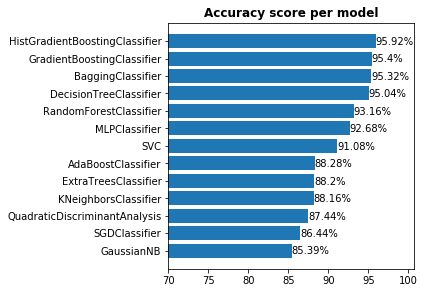

In [20]:
scores = []
names = []

#Getting the best score found by GridSearch for every classifiers
for clf in all_data:
    scores.append(clf.best_score_)
    names.append(str(clf.best_estimator_).split('(')[0])

best_estimators = pd.DataFrame()
best_estimators['Name']=names
best_estimators['Score']=pd.Series(scores) *100
best_estimators.sort_values(by='Score',inplace=True)

#Plotting the best accuracy score for every classifiers
plot = plt.barh(y = np.arange(len(names)), width = best_estimators['Score'], tick_label = best_estimators['Name'])
plt.axis(xmin = 70.0)
plt.tight_layout()
plt.title('Accuracy score per model',fontweight='bold')

for i in plot.patches:
    plt.text(y=i.get_y()+0.2,x=i.get_width(),s='{}%'.format(round(i.get_width(),2)))


In [21]:
estimators = []

for data,name in zip(all_data,names):
    estimators.append((name,data.best_estimator_))

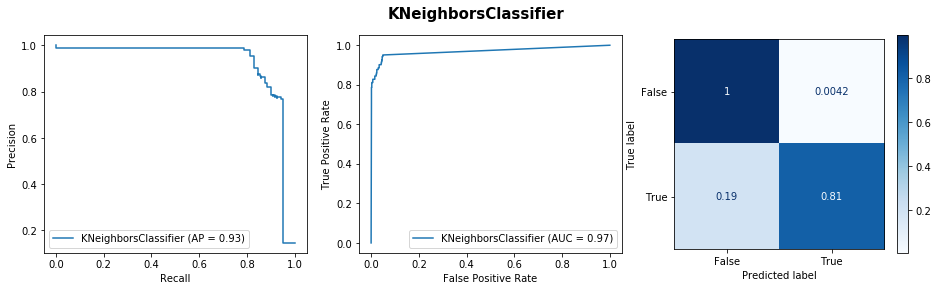

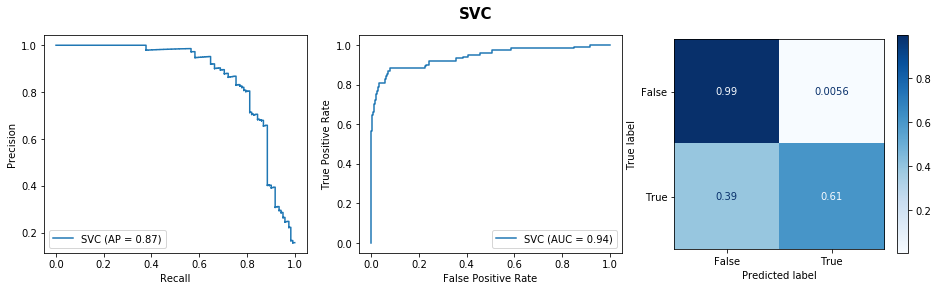

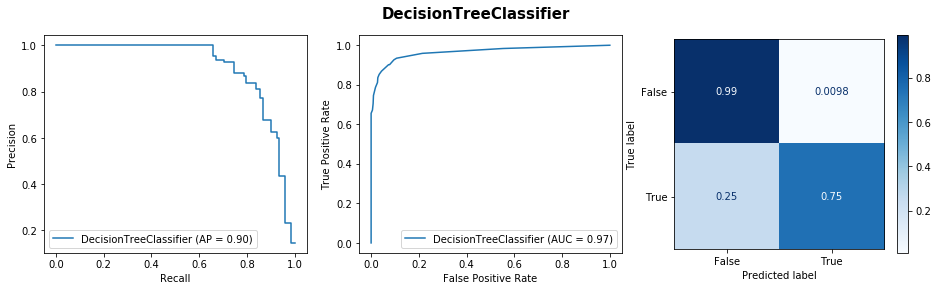

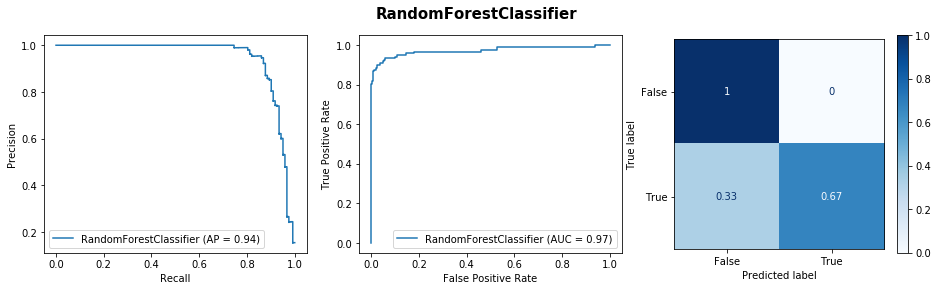

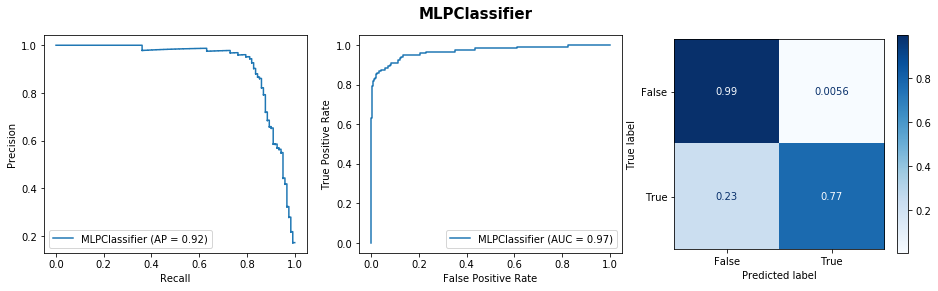

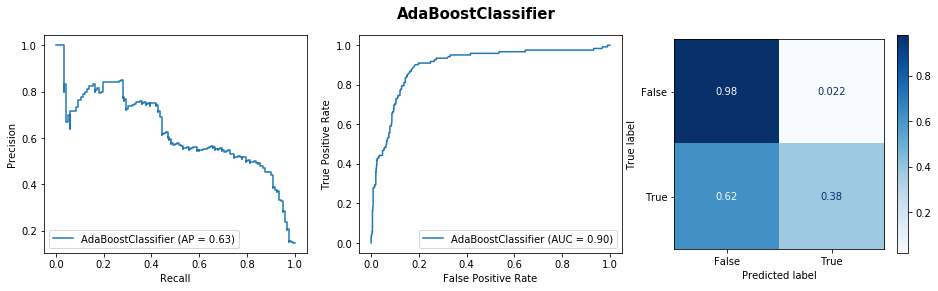

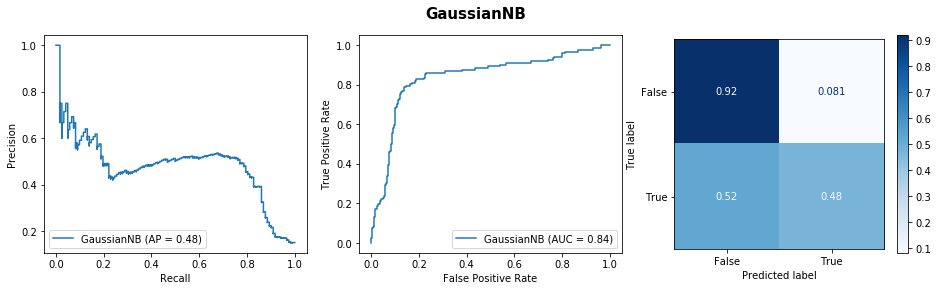

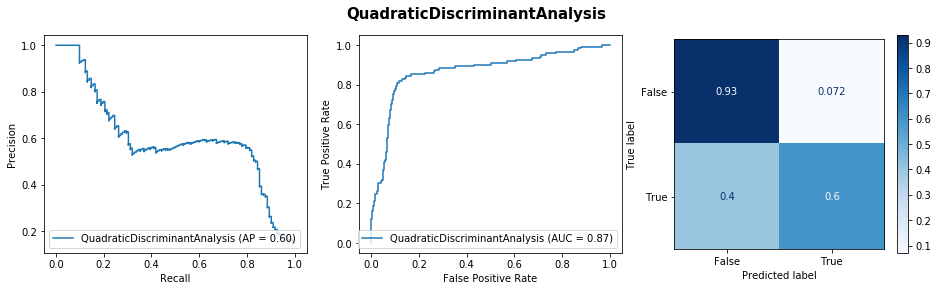

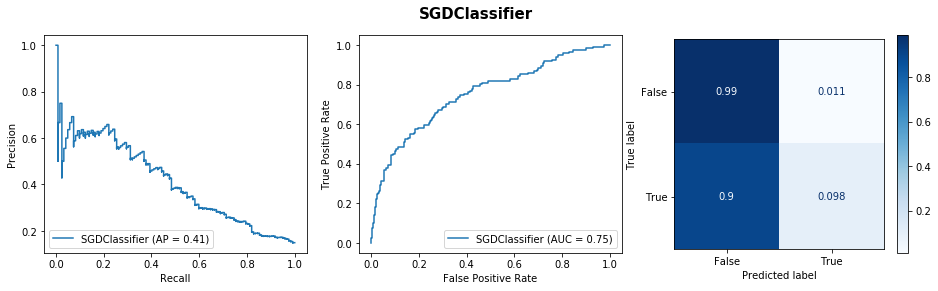

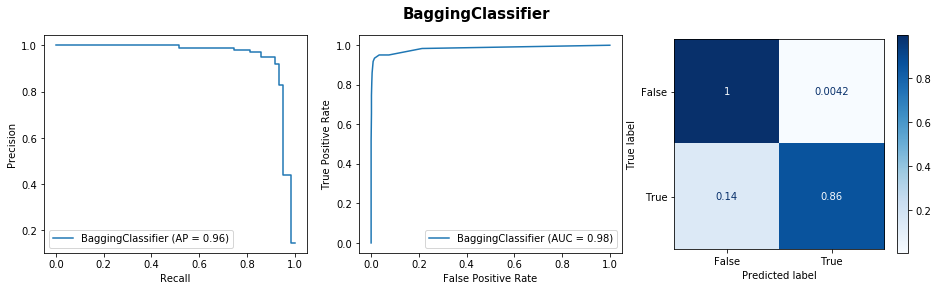

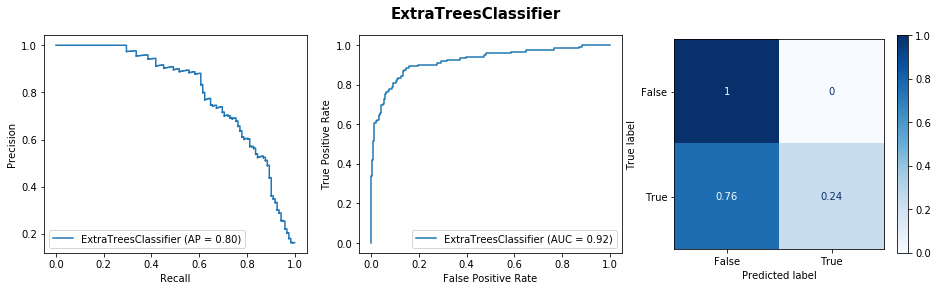

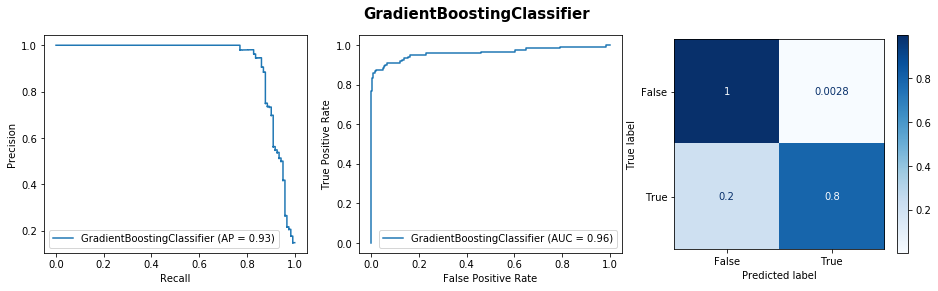

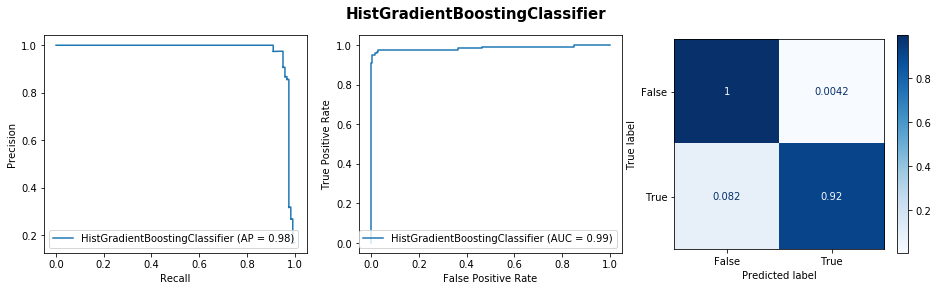

In [22]:
for clf in estimators:
    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(16,4))
    
    fig.suptitle(clf[0],fontsize=15,fontweight='bold')
    clf = clf[1]
    
    metrics.plot_precision_recall_curve(clf,X_test,y_test,ax=ax1)
    metrics.plot_roc_curve(clf,X_test,y_test,ax=ax2)
    metrics.plot_confusion_matrix(clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true',ax=ax3)

Looking at the confusion matrices we can see that even if all the models have an accuracy above 85% a lot of them struggles to predict quitting customers.<br><br>
We want the model with the highest true positive rate (bottom right cell). In our case it is the HistGradientBoostingClassifier.<br>

__Precision-Recall curve__

The Precision-Recall curve represents the average precision for every recall value measured.<br>
Reminder:
- Precision = True Positive / (True Positive + False Positive)
- Recall = True Positive / (True Positive + False Negative)

The Average Precision (AP) summarizes the Precision-Recall curve. It is between 0 and 1. The more is the better, meaning a classifier with a AP of one is a excellent classifier.<br>

__ROC curve__

The receiver operating characteristic (ROC) curve represents the true positives rate as a function of the false positives rate.
- True Positive Rate = Recall
- False Positive Rate = False Positive / (False Positive + True Negative)

The Area Under the Curve (AUC) summarizes the ROC curve. As indicated by his name it represents the area under the ROC curve. This metrics is also between 0 and 1. The more is the better.<br><br>

Good classifiers would have these curves (Recall-Precision and ROC) making right angle.

## Voting classifier

C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


Accuracy: 0.935251798561151


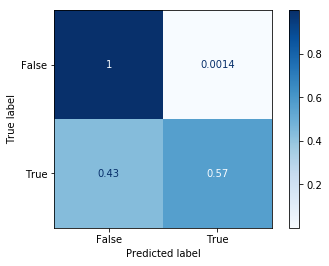

In [23]:
voting_clf = VotingClassifier(estimators)
voting_clf.fit(X_train,y_train)
print('Accuracy: '+str(voting_clf.score(X_test,y_test)))
metrics.plot_confusion_matrix(voting_clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true')

The result is not satisfaying, the model predicts just a litle more than one customer on two that will leave. __The model that we will select is HistGradientBoostingClassifier__.

C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\ppike\Anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


Accuracy: 0.9508393285371702


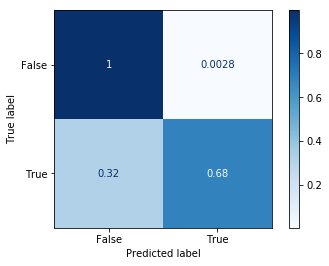

In [24]:
voting_estimators_name = best_estimators[best_estimators['Score']>95]['Name']
voting_estimators = []

for c in estimators:
    for n in voting_estimators_name:
        if c[0] == n:
            voting_estimators.append(c)
            
voting_clf = VotingClassifier(voting_estimators)
voting_clf.fit(X_train,y_train)
print('Accuracy: '+str(voting_clf.score(X_test,y_test)))
metrics.plot_confusion_matrix(voting_clf,X_test,y_test,cmap=plt.cm.Blues,normalize='true')

The voting classifier did not increase the number of true positive even keeping the best models.

# Focusing on trees

In [25]:
names = ['dtc','rfc','etc']

classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=10),
    ExtraTreesClassifier(n_estimators=10)]

parameters = [
    {'criterion':('gini','entropy'),'splitter':('best','random'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),\
              'min_samples_leaf':range(1,10)},
    {'criterion':('gini','entropy'),'max_depth':range(1,10),'min_samples_split':range(2,10),'min_samples_leaf':range(1,10)}
]

best_trees_estimators = []

In [26]:
if redo_training == True:
    for clf,param,name in zip(classifiers,parameters,names):
        #print(clf,param)
        clf = GridSearchCV(clf,param,cv=5,verbose=1,n_jobs=-1)
        clf.fit(X_train,y_train)
        best_trees_estimators.append((name,clf.best_estimator_))
        print(name, clf.best_score_)
        
    #Saving the data to a pickle file to avoid recomputing
    date = datetime.datetime.now()
    date = date.strftime('%Y-%m-%d_%H-%M')

    pickle.dump(best_trees_estimators,open('pickle_files/churn_trees_estimators_'+date+'.pickle','wb'))
    print('best_trees_estimators was saved in pickle_files/churn_trees_estimators_'+date+'.pickle')
else:
    best_trees_estimators = pickle.load(open(path_trees_estimators,'rb'))

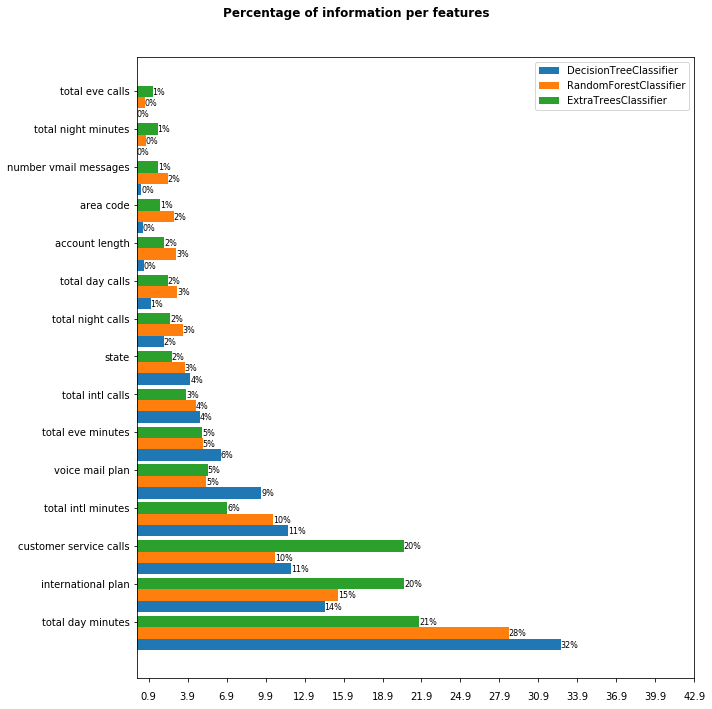

In [27]:
fig,axis = plt.subplots()
fig.suptitle('Percentage of information per features',fontweight='bold')

x = np.arange((len(churn.columns)-1)*3,step =3)  # the label locations
width = 0.9  # the width of the bars

names = []
n = 0 
axis.set_xticks(x)


for clf in best_trees_estimators:
    
    coord = x + n*width
    n = n+1
    
    feature_importance = pd.DataFrame(index=churn.columns)
    feature_importance.drop(index=['churn'],inplace=True)
    
    name = str(clf[1]).split('(')[0]
    names.append(name)
    
    clf = clf[1]
    clf = clf.fit(X_train,y_train)
    
    
    feature_importance['Percentage']= clf.feature_importances_ * 100
    feature_importance.sort_values(by='Percentage',inplace=True,ascending=False)

    
    axis.barh(y = coord,tick_label=feature_importance.index,width=feature_importance['Percentage'],height=width,label=name)

    
for i in axis.patches:
    axis.text(x = i.get_width(),y = i.get_y()+0.2,s = "{}{}".format(int(i.get_width()),'%'),fontsize=8)
    

plt.xticks(x+width)
axis.legend()
axis.tick_params(axis='x', which='major', pad=10)
fig.set_size_inches(h=10,w=10)
plt.tight_layout(rect=[0, 0, 1,0.93])


The graph above represents the percentage of information brought by the features for each tree model.
we can notice that:
- the total day minutes feature is most the important
- the ExtraTreesClassifier model gives importance to more features, it is also the tree model with the worst results

If we remember the correlation matrix, we notice that the churn was slightly correlated with the international_plan and the total_day_minutes features